<a href="https://colab.research.google.com/github/ankurmahesh/noaa_ai_workshop/blob/main/Seasonal_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EDA + TDA**

- Max Evans (ClimateAI)
- Ali Macias (ClimateAI)


## Introduction


El Niño/ Southern Oscillation (ENSO) is the dominant mode of variability that affects the climate on seasonal time scales.  It is measured by the Nino3.4 index, a rolling 3-month average of equatorial Pacific temperatures.  ENSO is an oscillation and is marked by two phases: El Niño, with anomalously warm equatorial Pacific temperatures, and La Niña, with anomlously cold temperatures.  Because El Niño is tied to many weather patterns around the world, such as the Indian monsoon, hurricanes in the Atlantic, and North American temperature, accurate ENSO forecasts are valuable for climate-sensitive sectors (such as agriculture, water, and energy).

Existing El Niño forecasts utilize dynamical models, from the European Center for Medium-range Weather Forecasts and the National Center for Environmental Prediction. These dynamical models issue forecasts by modeling the physics of the atmosphere and ocean.  In this notebook, we explore the ENSO patterns using Topological Data Analysis Techniques






## Software Requirements

This notebook requires the following libraries: numpy, xarray, netCDF4, pandas, matplotlib, sklearn, tqdm, pytorch, scipy.  Furthermore, it is *strongly* recommended that you use this notebook on Google Colab for ease of use and for access to GPU resources.

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split


## Data


*   [Nino3.4 Indices](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/): The Nino3.4 index measures the 3-month rolling average of equatorial Pacific Ocean temperature anomalies.




### Variables

Nino3.4 index (K): this metric indicates the state of ENSO.



### Training Set

Baseline training set: Training on **1980-1995 sea Surface temperatures** and their corresponding Nino3.4 Index at lead times (1 month to 5 months)

### Val Set
**1997-2006 sea surface temperatures** and their corresponding Nino3.4 Index at lead times.

### Test Set: 

Test on **2007-2017 sea surface temperatures** and their corresponding Nino3.4 Index at lead times (1 month to 5 month).


### Machine Learning Fundamentals

In this section, we will cover the fundamentals of machine learning!  We will refer to chapters from Professor Jonathan Shewchuk's excellent lecture notes from CS189 (UC Berkeley's Machine Learning class) as well as course notes developed by TAs including Garrett Thomas and Soroush Nasiriany. These notes provide a rigorous mathematical basis of the foundations of machine learning, and they are very helpful for developing the intuition behind tackling machine learning problems.  If you are interested in going deeper into machine learning, I strongly recommend reading these two resources.

*   Professor Shewchuk's lecture notes can be found at this [link ](https://people.eecs.berkeley.edu/~jrs/papers/machlearn.pdf)
*   Nasiriany and Thomas's course notes can be found at this [link ](http://snasiriany.me/files/ml-book.pdf)

In [ ]:
#Download the required packages and the data that we will use 
#for this tutorial

!pip install netCDF4

!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt

URL transformed to HTTPS due to an HSTS policy
--2023-03-27 11:13:17--  https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.110, 128.55.206.108, 128.55.206.112, ...
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15449 (15K) [text/plain]
Saving to: ‘nino34.long.anom.data.txt.1’

nino34.long.anom.da 100%[===================>]  15.09K  --.-KB/s    in 0.08s   

2023-03-27 11:13:18 (199 KB/s) - ‘nino34.long.anom.data.txt.1’ saved [15449/15449]



In [ ]:
#Scaffold code to load in data.  This code cell is mostly data wrangling

def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals


def plot_nino_time_series(y, predictions, title):
  """
  inputs
  ------
    y           pd.Series : time series of the true Nino index
    predictions np.array  : time series of the predicted Nino index (same
                            length and time as y)
    titile                : the title of the plot

  outputs
  -------
    None.  Displays the plot
  """
  predictions = pd.Series(predictions, index=y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()

  plt.plot(y, label='Ground Truth')
  plt.plot(predictions, '--', label='ML Predictions')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Nino3.4 Index')
  plt.xlabel('Date')
  plt.show()
  plt.close()


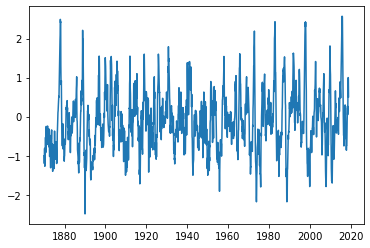

In [ ]:

plt.plot(load_enso_indices()[0:-11], label='Ground Truth')
plt.show()

# EDA


